In [1]:
import scanpy as sc
import pandas as pd
import declust as dc
import seaborn as sns
import matplotlib.pyplot as plt

Loading Data



In [2]:
# Load your spatial data and your single cell data (which should be in AnnData format)

sc_adata = sc.read_h5ad('simulation_data/sc_adata.h5ad')
sc_adata.var_names_make_unique()
sc_adata_raw = sc_adata.copy()

st_adata = sc.read_h5ad('simulation_data/st_simu_adata.h5ad')
st_adata.var_names_make_unique()
st_adata_raw = st_adata.copy()

coords_df = st_adata.obs.rename(columns={'array_row': 'x', 'array_col': 'y'})[['x', 'y']]

Data Preprocessing

In [3]:
# Normalization

sc.pp.normalize_total(st_adata, target_sum=1e4)
sc.pp.log1p(st_adata)

sc.pp.normalize_total(sc_adata, target_sum=1e4)
sc.pp.log1p(sc_adata)

In [4]:
# Selection of highly variable genes for marker gene identification and clustering

st_top_500_genes_df = st_adata[
    :, dc.preprocessing.select_highly_variable_genes(st_adata, n_top_genes=500)
].to_df()

high_variable_common_genes = set(
    dc.preprocessing.select_highly_variable_genes(st_adata, n_top_genes=5000)
).intersection(sc_adata.var_names)

sc_adata_overlapped = sc_adata_raw[:, list(high_variable_common_genes)].copy()
sc_labels = dc.preprocessing.extract_labels_from_scdata(
    sc_adata_overlapped, celltype_col='celltype_major', sample_col='Patient'
)

In [5]:
# Save the data for next steps

sc_adata_overlapped.write('simulation_data/sc_adata_overlapped.h5ad')
sc_labels.to_csv('simulation_data/sc_labels.csv')

Built Reference Matrix


In [6]:
# Build a cell type reference matrix from annotated scRNA seq data.

sc_marker_gene_df = dc.marker_selection.generate_marker_genes('simulation_data/sc_adata_overlapped.h5ad', 'simulation_data/sc_labels.csv', 'simulation_data/marker_genes.csv')

In [7]:
sc_adata_marker = sc_adata_raw[:, sc_adata.var_names.isin(sc_marker_gene_df.index)].copy()

Clustering

In [8]:
# Hierarchical Clustering 

# This function clusters spatial transcriptomics spots based on 
# the similarity of their highly variable gene expression profiles.

hierarchical_results_df = dc.hierarchical.clustering(st_top_500_genes_df, coords_df)

Running Hierarchical Clustering...
Using automatically selected number of clusters: 8


In [9]:
# DBSCAN Clustering
  
# This function refines the initial clustering by applying DBSCAN to the results of the 
# hierarchical clustering. It also selects the initial seeds for the SRG. 
# You can choose to visualize the DBSCAN clustering results.

dbscan_centers_df = dc.dbscan.clustering(hierarchical_results_df, coords_df, eps = 4, min_samples = 8)

Running DBSCAN clustering...


Running Seeded Region Growing...


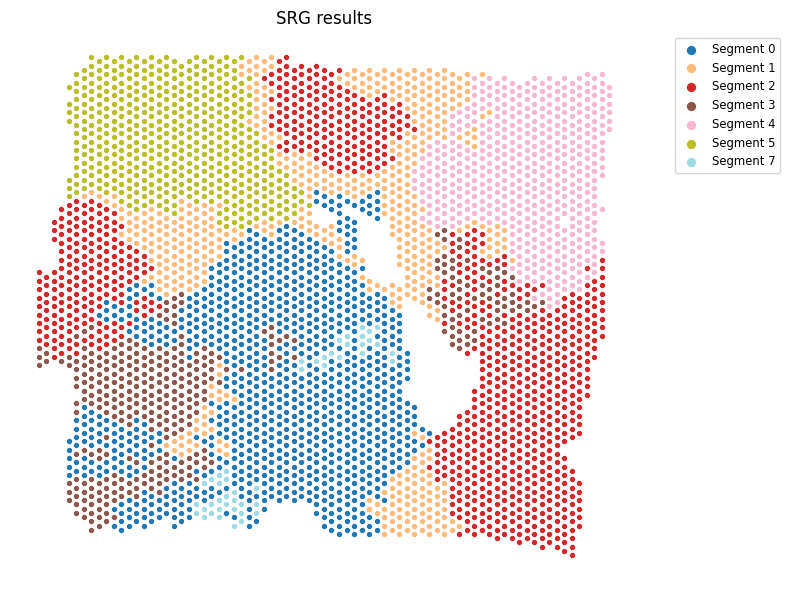

In [10]:
# Seeded Region Growing (SRG)

# Finally, the SRG function further refines the clusters.

srg_df = dc.srg.clustering(dbscan_centers_df, coords_df, st_top_500_genes_df, show_plot = True)

Deconvolution

In [11]:
# You may export the pseudo-bulk gene expression profiles aggregated
# by spatial clusters by this function:

dc.deconvolution.generate_pseudo_bulk(
    st_adata_raw, srg_df, save_csv=True, output_path="simulation_results/pseudo_bulk.csv"
)

Pseudo-bulk expression data saved to: simulation_results/pseudo_bulk.csv


,RP11-34P13.7,FO538757.3,FO538757.2,AP006222.2,RP4-669L17.10,RP5-857K21.4,RP11-206L10.9,LINC00115,FAM41C,RP11-54O7.3,...,GRXCR1,RP11-63A1.2,CTD-2514K5.4,RP11-112L7.1,RP11-231G15.2,RP11-983C2.3,LINC00919,RP11-589P10.7,KRTAP9-2,IGLVIV-66-1
0,276.0,206.0,19860.0,10777.0,603.0,315.0,4477.0,2839.0,1961.0,366.0,...,0.0,2.0,4.0,4.0,0.0,0.0,0.0,2.0,3.0,8.0
1,121.0,61.0,7249.0,4428.0,239.0,166.0,1656.0,904.0,734.0,123.0,...,0.0,1.0,6.0,1.0,0.0,3.0,0.0,1.0,2.0,19.0
2,302.0,232.0,19432.0,9720.0,508.0,328.0,4387.0,2753.0,1754.0,399.0,...,0.0,1.0,5.0,0.0,0.0,1.0,0.0,0.0,0.0,7.0
3,114.0,99.0,7619.0,3801.0,235.0,119.0,1702.0,1060.0,699.0,150.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,223.0,262.0,19253.0,8689.0,394.0,273.0,3478.0,2610.0,1747.0,428.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,2.0,3.0
5,155.0,97.0,8359.0,5554.0,280.0,182.0,1905.0,1089.0,868.0,327.0,...,0.0,0.0,2.0,0.0,0.0,7.0,0.0,0.0,0.0,9.0
7,19.0,8.0,980.0,494.0,16.0,20.0,199.0,146.0,100.0,21.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [12]:
# This function performs deconvolution using the OLS method.

DECLUST_df = dc.deconvolution.ols(st_adata_raw, sc_adata_marker, srg_df, celltype_col= 'celltype_major')

Running deconvolution...


Results visulization

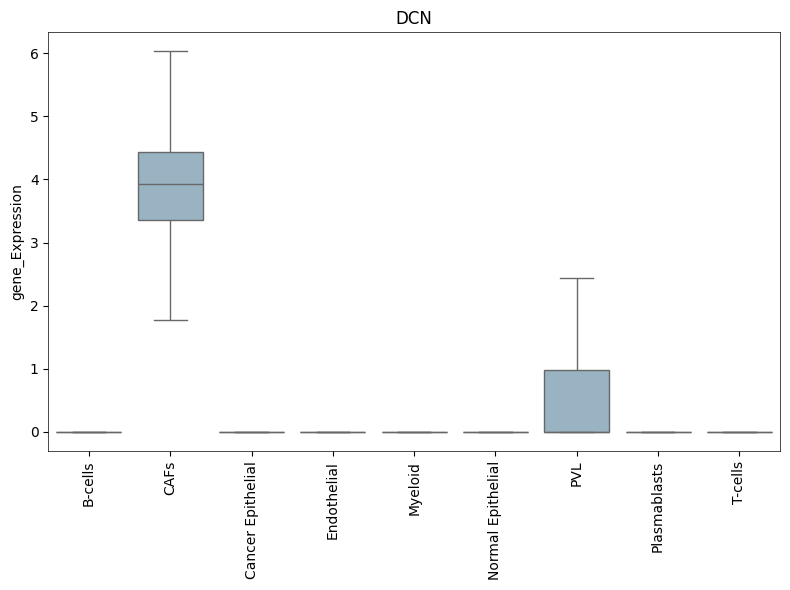

In [13]:
# Cell-Type-Specific Marker Gene Expression

# The `dc.visualize.declust_marker_boxplot` function displays the expression levels of 
# top cell-type-specific marker genes across different cell types in the scRNA-seq reference 
# data. This helps validate the specificity of selected markers.

dc.visualize.declust_marker_boxplot(sc_adata, sc_marker_gene_df, 'DCN', 'celltype_major')

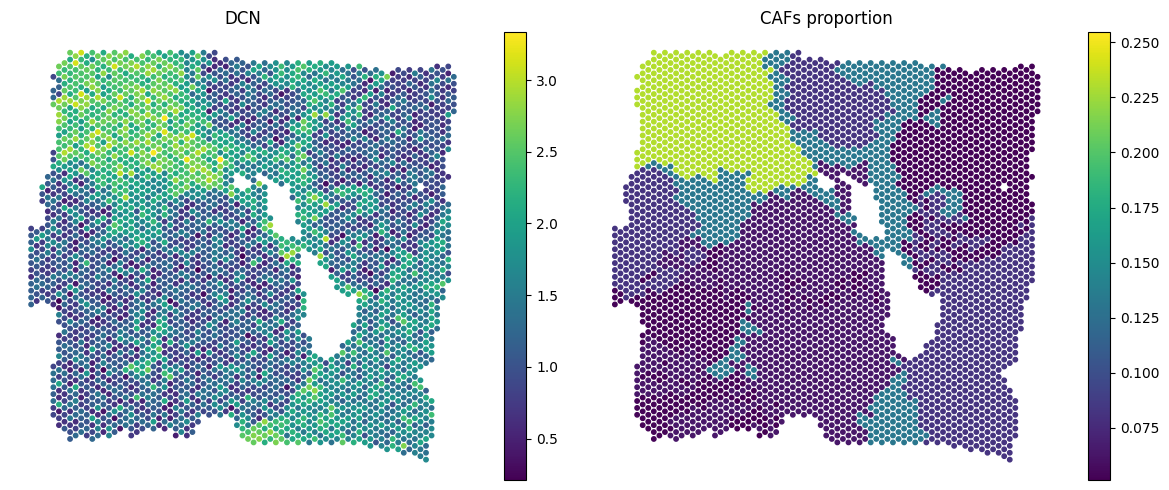

In [14]:
# Spatial Visualization of Deconvolution Results

# The `dc.visualize.declust_results_visualize` function displays the spatial distribution 
# of deconvolved cell type proportions, along with expression patterns of marker genes in 
# the spatial transcriptomics data.

dc.visualize.declust_results_visualize(
    st_adata, sc_marker_gene_df, DECLUST_df, coords_df,
    gene_name='DCN', cell_type='CAFs'
)

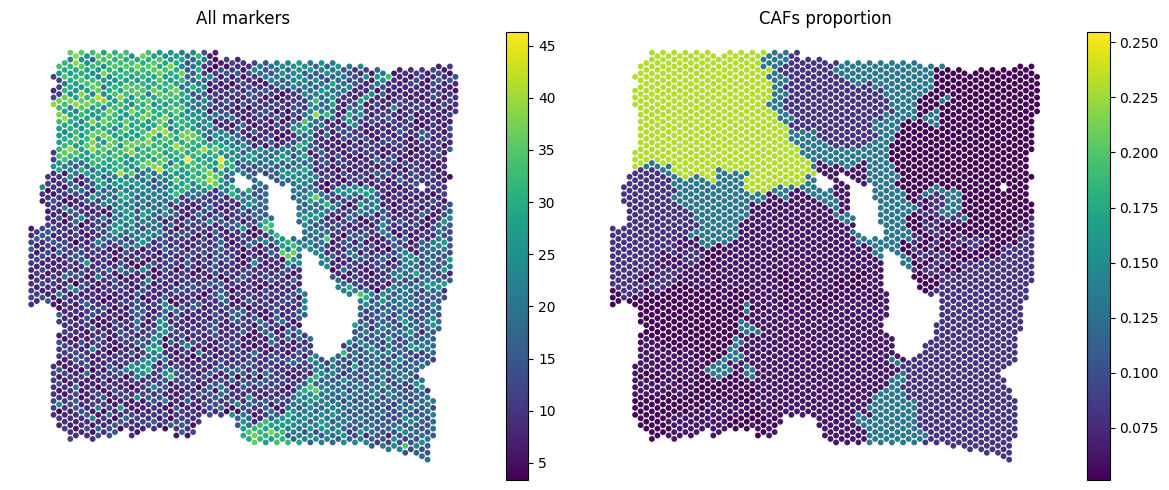

In [15]:
dc.visualize.declust_results_visualize(
    st_adata, sc_marker_gene_df, DECLUST_df, coords_df,
    cell_type='CAFs', agg_method='sum'
)

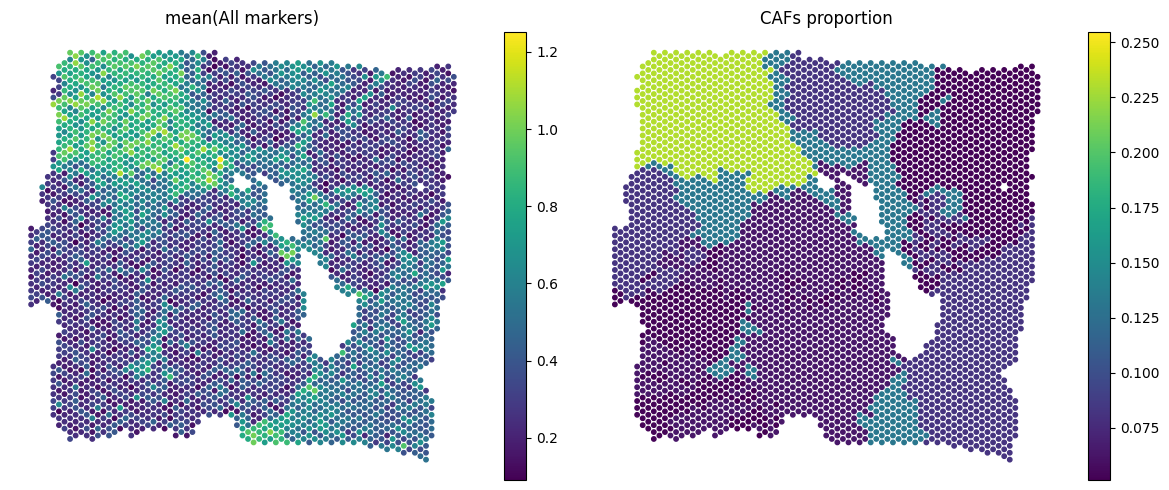

In [16]:
dc.visualize.declust_results_visualize(
    st_adata, sc_marker_gene_df, DECLUST_df, coords_df,
    cell_type='CAFs', agg_method='mean'
)

Evaluation

In [17]:
ground_truth = pd.read_csv('simulation_data/simulated_ground_truth_proportions.csv', index_col = 0)

In [18]:
DECLUST_df = DECLUST_df.loc[ground_truth.index]

In [19]:
mean_squared_error = ((DECLUST_df - ground_truth) ** 2).mean(axis=1)
rmse_per_spot = mean_squared_error.apply(lambda x: x ** 0.5)
rmse_df = rmse_per_spot.rename("DECLUST").to_frame()

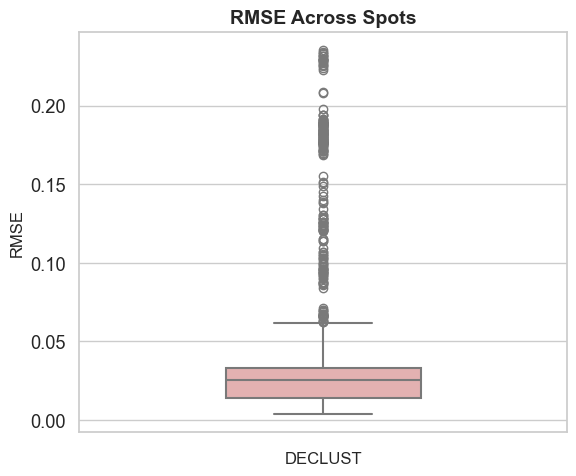

In [20]:
sns.set(style="whitegrid", palette="pastel", font_scale=1.2)

fig, ax = plt.subplots(figsize=(6, 5))

sns.boxplot(data=rmse_df, y="DECLUST", ax=ax, color="#ECA8A9", linewidth=1.5, width=0.4)

ax.set_title("RMSE Across Spots", fontsize=14, weight='bold')
ax.set_ylabel("RMSE", fontsize=12)
ax.set_xlabel("DECLUST", fontsize=12)

plt.tight_layout()
plt.show()